In [2]:
import pandas as pd
import numpy as np

In [33]:
%%time
dfname = "tweets_AAPL_1.csv"
with open(dfname,'rb') as dfile:
    dstr = str(dfile.read())[1:5]
    
darr = dstr.split('\\r')
dmat = [rs.split(",") for rs in darr]
dmat = [r[:1] + [",".join(r[1:-5])] + r[-5:] for r in dmat]
dmat = [r for r in dmat if len(r) == 7]
df = pd.DataFrame(dmat)
df.columns = ["datestr","twt","open","high","low","close","adjclose"]
df["twtarr"] = df["twt"].apply(lambda text: text.lower().split())

ValueError: Length mismatch: Expected axis has 0 elements, new values have 7 elements

In [32]:
%%time
df.to_csv("aapltwt/"+dfname)

CPU times: user 4.89 s, sys: 307 ms, total: 5.2 s
Wall time: 6.55 s


In [28]:
i = 5

In [5]:
from datetime import datetime

In [6]:
df = df[df["datestr"] != ""]
%time df["date"] = df["datestr"].apply( \
    lambda date: datetime.strptime(date,"%m/%d/%y"))
datedf = df[["date","open"]].groupby("date").aggregate(lambda gp: tuple(set(gp))[0])
pval = datedf.values.astype(float)
up = ((pval[1:] - pval[:-1]) > 0).astype(int)
datedf["openup"] = list(up.T[0]) + [0]

CPU times: user 4.37 s, sys: 101 ms, total: 4.47 s
Wall time: 6.11 s


In [7]:
%time df["openup"] = df["date"].apply(lambda date: datedf["openup"].loc[date])

CPU times: user 15 s, sys: 254 ms, total: 15.3 s
Wall time: 18.1 s


In [8]:
import gensim
%time w2vM = gensim.models.Word2Vec(df["twtarr"])

CPU times: user 56.8 s, sys: 875 ms, total: 57.6 s
Wall time: 31.8 s


In [9]:
# number of samples to aggregate
Ns = int(1e6)

In [10]:
%%time
# MEAN AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).mean(axis=0)
#                  for twt in df["twtarr"][:Ns]])
# tvecs = np.array([np.array([w2vM[t]
#                             for t in twt
#                             if t in w2vM]).mean(axis=0)
#                  for twt in df["twt"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])
# MEAN AGGREGATION
%time df["twtvecs"] = df["twtarr"][:Ns].apply(\
    lambda twt: np.array([w2vM[t] \
                         if t in w2vM else np.zeros((100,)) \
                         for t in twt]).mean(axis=0))

CPU times: user 26.6 s, sys: 889 ms, total: 27.5 s
Wall time: 34.3 s
CPU times: user 26.6 s, sys: 893 ms, total: 27.5 s
Wall time: 34.3 s


In [11]:
print(df.shape)
%time veclens = df["twtvecs"].apply(lambda vec: int(np.prod(vec.shape)))
df_empty = df[veclens != 100]
%time df = df[veclens == 100]
print(df.shape)

(221343, 11)
CPU times: user 2.27 s, sys: 153 ms, total: 2.42 s
Wall time: 2.65 s
CPU times: user 63.8 ms, sys: 10.6 ms, total: 74.4 ms
Wall time: 87.2 ms
(221343, 11)


In [12]:
dategps = df[["date","twtvecs"]].groupby("date")
datevecs = [np.mean(gp.values[:,1], axis=0) for k,gp in dategps]
datedf["datevecs"] = datevecs

In [13]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

def roc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

# Average of tweets in a day

In [14]:
# dvecs = np.array([vec.T for vec in avgvecs["vecs"].values])
X = np.array([vec.T for vec in datedf["datevecs"].values])
y = datedf["openup"].values
# inverse classifier
# y = 1 - y

In [15]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(X.shape[0]) < ratio
pidx = ~tidx

CPU times: user 31.9 ms, sys: 2.33 ms, total: 34.2 ms
Wall time: 32.5 ms
TEST
Accuracy 0.571428571429 Precision 0.666666666667 Recall 0.56 F1 0.608695652174
CPU times: user 3.61 ms, sys: 746 µs, total: 4.35 ms
Wall time: 3.98 ms
TRAIN
Accuracy 0.953846153846 Precision 0.923728813559 Recall 1.0 F1 0.960352422907
CPU times: user 4.62 ms, sys: 1.03 ms, total: 5.65 ms
Wall time: 5.04 ms
ROC AUC


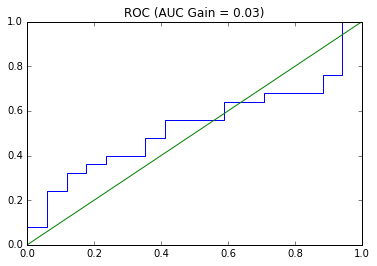

CPU times: user 245 ms, sys: 17.1 ms, total: 262 ms
Wall time: 326 ms
PRECISION/RECALL AUC


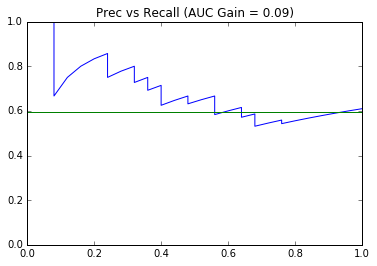

CPU times: user 231 ms, sys: 11.8 ms, total: 243 ms
Wall time: 311 ms


In [16]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

/Users/aduriseti/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


CPU times: user 388 ms, sys: 34.1 ms, total: 422 ms
Wall time: 468 ms
TEST
Accuracy 0.642857142857 Precision 0.727272727273 Recall 0.64 F1 0.68085106383
CPU times: user 2.14 ms, sys: 1.01 ms, total: 3.15 ms
Wall time: 2.57 ms
TRAIN
Accuracy 0.789743589744 Precision 0.798245614035 Recall 0.834862385321 F1 0.816143497758
CPU times: user 2.41 ms, sys: 816 µs, total: 3.23 ms
Wall time: 2.52 ms
ROC AUC


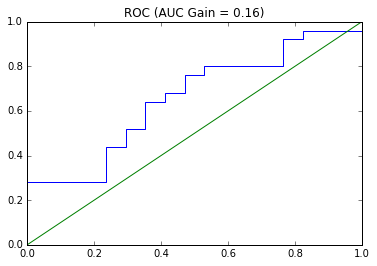

CPU times: user 187 ms, sys: 6.17 ms, total: 193 ms
Wall time: 202 ms
PRECISION/RECALL AUC


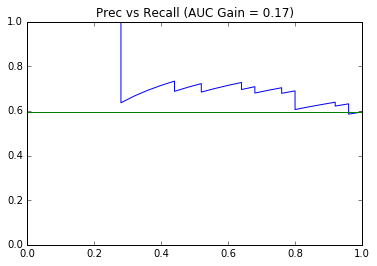

CPU times: user 215 ms, sys: 11.9 ms, total: 226 ms
Wall time: 227 ms


In [17]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 14.1 ms, sys: 10.4 ms, total: 24.5 ms
Wall time: 44 ms
TEST
Accuracy 0.595238095238 Precision 0.595238095238 Recall 1.0 F1 0.746268656716
CPU times: user 1.8 ms, sys: 587 µs, total: 2.39 ms
Wall time: 1.93 ms
TRAIN
Accuracy 1.0 Precision 1.0 Recall 1.0 F1 1.0
CPU times: user 3.1 ms, sys: 1.03 ms, total: 4.13 ms
Wall time: 3.06 ms
ROC AUC


/Users/aduriseti/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


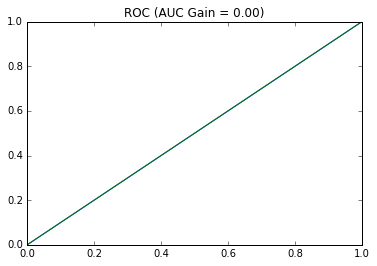

CPU times: user 221 ms, sys: 11.9 ms, total: 233 ms
Wall time: 236 ms
PRECISION/RECALL AUC


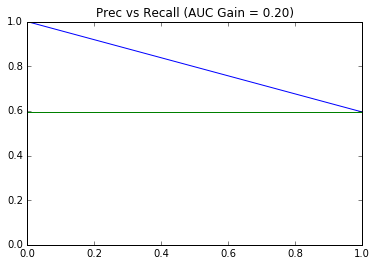

CPU times: user 194 ms, sys: 7.58 ms, total: 202 ms
Wall time: 205 ms


In [18]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

# Single tweets

In [19]:
# number of samples to train on
N = int(1e6)
X = np.array([x.T for x in df["twtvecs"][:N].values])
y = df["openup"][:N].values
# inverse classifier
# y = 1 - y

In [20]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(min(X.shape[0],N)) < ratio
pidx = ~tidx

CPU times: user 14.4 s, sys: 432 ms, total: 14.8 s
Wall time: 19.3 s
TEST
Accuracy 0.576429722796 Precision 0.572461577809 Recall 0.989192446766 F1 0.725224230106
CPU times: user 79.2 ms, sys: 35.4 ms, total: 115 ms
Wall time: 129 ms
TRAIN
Accuracy 0.577599043408 Precision 0.572439797358 Recall 0.990414440375 F1 0.725534893608
CPU times: user 305 ms, sys: 112 ms, total: 418 ms
Wall time: 576 ms
ROC AUC


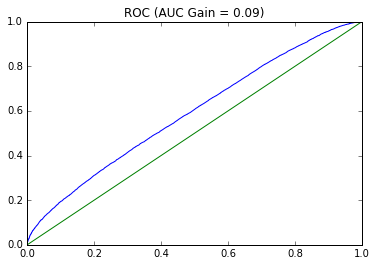

CPU times: user 302 ms, sys: 32.1 ms, total: 334 ms
Wall time: 428 ms
PRECISION/RECALL AUC


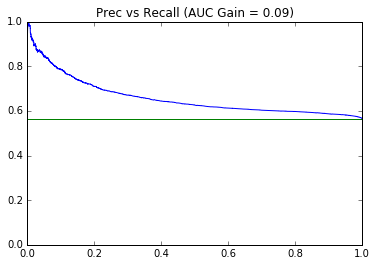

CPU times: user 312 ms, sys: 26.9 ms, total: 339 ms
Wall time: 404 ms


In [21]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 2min 39s, sys: 18 s, total: 2min 57s
Wall time: 3min 10s
TEST
Accuracy 0.700501736781 Precision 0.736763277202 Recall 0.731257533146 F1 0.734000080655
CPU times: user 169 ms, sys: 182 ms, total: 351 ms
Wall time: 316 ms
TRAIN
Accuracy 0.744906822489 Precision 0.774825455824 Recall 0.771747613616 F1 0.773283472106
CPU times: user 587 ms, sys: 350 ms, total: 937 ms
Wall time: 1.17 s
ROC AUC


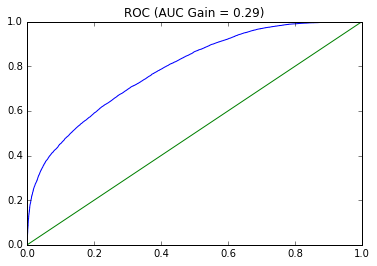

CPU times: user 355 ms, sys: 116 ms, total: 472 ms
Wall time: 474 ms
PRECISION/RECALL AUC


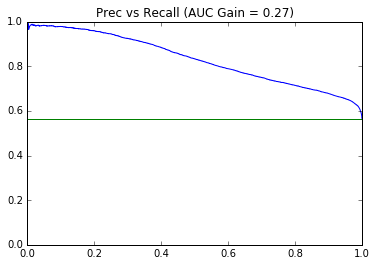

CPU times: user 378 ms, sys: 64.5 ms, total: 442 ms
Wall time: 452 ms


In [22]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 5.95 s, sys: 595 ms, total: 6.55 s
Wall time: 6 s
TEST
Accuracy 0.601221422571 Precision 0.659579103307 Recall 0.608196062676 F1 0.63284630338
CPU times: user 240 ms, sys: 142 ms, total: 382 ms
Wall time: 288 ms
TRAIN
Accuracy 0.611000812201 Precision 0.668219933959 Recall 0.61554701727 F1 0.640802891576
CPU times: user 1.1 s, sys: 867 ms, total: 1.97 s
Wall time: 2.03 s
ROC AUC


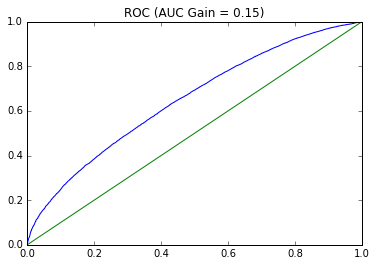

CPU times: user 452 ms, sys: 159 ms, total: 611 ms
Wall time: 592 ms
PRECISION/RECALL AUC


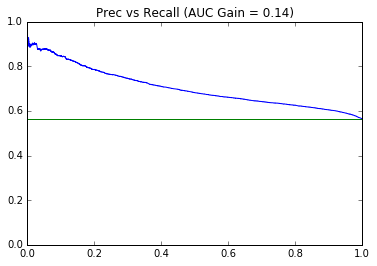

CPU times: user 457 ms, sys: 103 ms, total: 560 ms
Wall time: 497 ms


In [23]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])